In [155]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

base_url = 'https://www.sports-reference.com'

# Data Frame for all #1 teams
top_teams = pd.DataFrame()

# Looping through every year from 1949 (Start of AP polling) to most recent final AP Poll in 2020
for year in range(1949, 2021):
    # Sports-Reference uses a simple year as the page format
    season_url = base_url + '/cbb/seasons/' + str(year) + '.html'
    season_request = requests.get(season_url).text
    soup = BeautifulSoup(season_request, features='lxml')

    # Find on the page where AP Final #1 is found and extract team page and name
    ap_final = soup.find(text=re.compile('AP Final #1')).parent.parent.parent.find("a")
    team_page_url = ap_final.get("href")
    team_name = ap_final.text

    # Now go into each team page and extra data
    team_page_request = requests.get(base_url + team_page_url).text
    soup = BeautifulSoup(team_page_request, features='lxml')
    table_team_data = soup.find(id="team_stats")
    if table_team_data is None:
        # No team data exists for this team for this season
        continue
    table_team_data = table_team_data.findAll("tr")

    # Create data frame to append to, year will be index
    year = team_page_url[team_page_url.rfind("/") + 1:team_page_url.find(".html")]
    team_data = pd.DataFrame(index=[year])
    team_data['team'] = team_name
    # Gets year from url

    # First row is labels for stats
    # Second row is teams stats for
    for entries in table_team_data[1].findAll("td"):
        stat = entries.get("data-stat")
        team_data[stat] = entries.text

    # Third row is teams stats against. Some years have different third row, so this takes that into account
    against = 2
    if len(table_team_data) > 3:
        against = -2
    for entries in table_team_data[against].findAll("td"):
        stat = entries.get("data-stat") # + '_against'
        team_data[stat] = entries.text

    # Append our row to the ongoing list of AP #1 teams
    top_teams = top_teams.append(team_data)


# Move team name to the front of the df
names = top_teams['team']
top_teams.drop(['team'], axis = 1, inplace = True)
top_teams.insert(0, 'team_name', names)

In [156]:
top_teams.columns

Index(['team_name', 'ast', 'blk', 'drb', 'fg', 'fg2', 'fg2_pct', 'fg2a', 'fg3',
       'fg3_pct', 'fg3a', 'fg_pct', 'fga', 'ft', 'ft_pct', 'fta', 'g', 'mp',
       'opp_ast', 'opp_blk', 'opp_drb', 'opp_fg', 'opp_fg2', 'opp_fg2_pct',
       'opp_fg2a', 'opp_fg3', 'opp_fg3_pct', 'opp_fg3a', 'opp_fg_pct',
       'opp_fga', 'opp_ft', 'opp_ft_pct', 'opp_fta', 'opp_orb', 'opp_pf',
       'opp_pts', 'opp_pts_per_g', 'opp_stl', 'opp_tov', 'opp_trb', 'orb',
       'pf', 'pts', 'pts_per_g', 'stl', 'tov', 'trb'],
      dtype='object')

In [157]:
top_teams.tail()

,team_name,ast,blk,drb,fg,fg2,fg2_pct,fg2a,fg3,fg3_pct,...,opp_stl,opp_tov,opp_trb,orb,pf,pts,pts_per_g,stl,tov,trb
2016,Kansas,604,158,1041,1092,788,.533,1479,304,.418,...,248,490,1234,402,719,3089,81.3,253,478,1443
2017,Villanova,505,109,892,965,654,.592,1105,311,.369,...,185,475,1073,316,515,2779,77.2,259,402,1208
2018,Virginia,458,124,817,848,601,.501,1199,247,.383,...,130,432,1048,282,480,2283,67.1,232,290,1099
2019,Duke,606,257,1072,1157,879,.580,1515,278,.308,...,243,540,1348,495,595,3143,82.7,346,488,1567
2020,Kansas,432,145,863,851,652,.553,1180,199,.344,...,199,407,991,333,454,2312,74.6,237,396,1196


There is now an abundance of CBB data from each season's AP Poll 'Best Team' for each season starting at 1949 loaded into the top_teams DataFrame. All of the columns for statistics from the team's opponent start with the opp_ prefix. For example, the Total Rebounds statistic is kept under the 'trb' column, but opponent total rebounds are kept under the 'opp_trb' column. Additionally, the index of the row is the year in which the season was played. Furthermore, the final row in the DataFrame is the from 2019-2020 season.

# Data Processing
Let's convert all of the columns to their proper datatypes. A float is necessary for columns that are percentages or per game values. Integers will suffice for the rest.

In [159]:
# Convert non-name columns to float or int
import numpy as np
from plotnine import *

top_teams.replace(r'^\s*$', np.nan, regex=True, inplace = True)
for column in top_teams:
    if not column == 'team_name':
        top_teams[column] = top_teams[column].fillna(-1)
        if ('pct' in column) or ('per_g' in column):
            top_teams[column] = top_teams[column].astype(float)
        else:
            top_teams[column] = top_teams[column].astype(int)
    print(column + " type is " + str(type(top_teams[column][-1])))

team_name type is <class 'str'>
ast type is <class 'numpy.int64'>
blk type is <class 'numpy.int64'>
drb type is <class 'numpy.int64'>
fg type is <class 'numpy.int64'>
fg2 type is <class 'numpy.int64'>
fg2_pct type is <class 'numpy.float64'>
fg2a type is <class 'numpy.int64'>
fg3 type is <class 'numpy.int64'>
fg3_pct type is <class 'numpy.float64'>
fg3a type is <class 'numpy.int64'>
fg_pct type is <class 'numpy.float64'>
fga type is <class 'numpy.int64'>
ft type is <class 'numpy.int64'>
ft_pct type is <class 'numpy.float64'>
fta type is <class 'numpy.int64'>
g type is <class 'numpy.int64'>
mp type is <class 'numpy.int64'>
opp_ast type is <class 'numpy.int64'>
opp_blk type is <class 'numpy.int64'>
opp_drb type is <class 'numpy.int64'>
opp_fg type is <class 'numpy.int64'>
opp_fg2 type is <class 'numpy.int64'>
opp_fg2_pct type is <class 'numpy.float64'>
opp_fg2a type is <class 'numpy.int64'>
opp_fg3 type is <class 'numpy.int64'>
opp_fg3_pct type is <class 'numpy.float64'>
opp_fg3a type is 

In [ ]:
top_teams.head()

In [ ]:
top_teams.tail()

As you can see, all of the missing data has been encoded as -1, but the recent data is much more complete. 
Now that the data is in it's proper datatype, we can start exploring it.

# Exploratory Data Analysis
Let's start by finding out which schools have been the most successful at producing the AP Poll #1 Ranked team at the end of each season.

In [160]:
# Let's see which colleges have been AP Poll #1 ranked the most often, after each season
counts = top_teams.filter(['team_name', 'pts']).groupby(['team_name']).count()
counts['team_name'] = counts.index
counts.reset_index(drop = True, inplace = True)
counts.sort_values(by=['pts'], ascending = False, inplace = True)

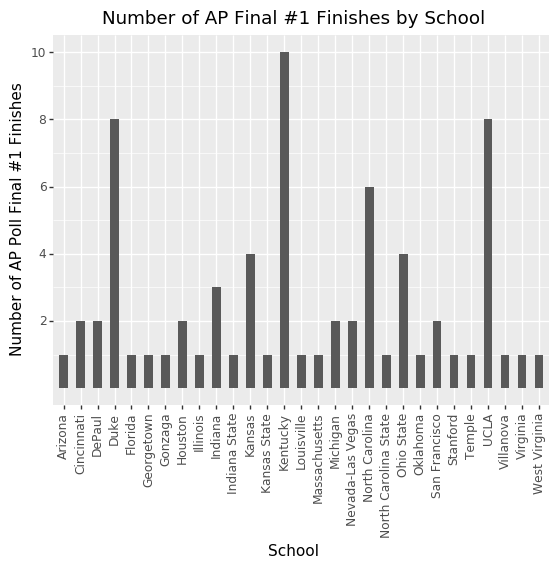

<ggplot: (299827385)>

In [161]:
(ggplot(counts, aes(x= 'team_name', y = 'pts')) +
theme(axis_text_x = element_text(angle=90)) +
xlab('School') + 
ylab('Number of AP Poll Final #1 Finishes') +
ggtitle('Number of AP Final #1 Finishes by School') +
scale_y_continuous(breaks=[2, 4, 6, 8, 10]) +
geom_col(width = 0.5))

Kentucky has acheived this feat a whopping 10 times. Duke and UCLA aren't far behind with 8 times, with North Carolina, Kansas, and Ohio State behind them at 4 times.

In [162]:
# Let's see how some key parts of basketball have changed over time. Let's start with points.
points = top_teams.filter(['team_name', 'pts_per_g', 'opp_pts_per_g'])
points['year'] = points.index.astype(int)
points.reset_index(drop = True, inplace = True)
points['differential'] = points['pts_per_g'] - points['opp_pts_per_g']
points.tail()

,team_name,pts_per_g,opp_pts_per_g,year,differential
66,Kansas,81.3,67.6,2016,13.7
67,Villanova,77.2,62.7,2017,14.5
68,Virginia,67.1,54.0,2018,13.1
69,Duke,82.7,67.8,2019,14.9
70,Kansas,74.6,60.7,2020,13.9


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


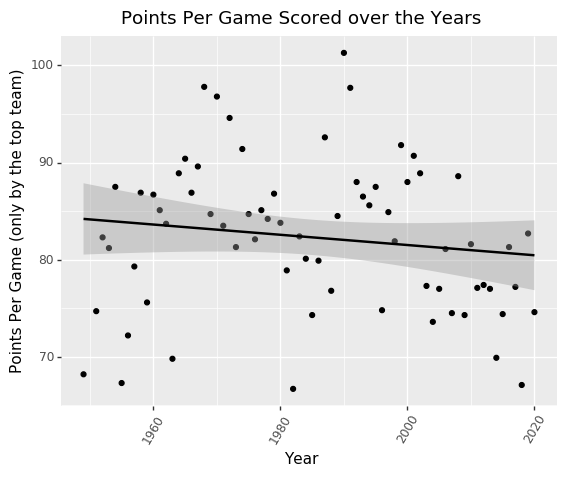

<ggplot: (7558571133)>

In [163]:
(ggplot(points, aes(x= 'year', y = 'pts_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Points Per Game (only by the top team) ') +
ggtitle('Points Per Game Scored over the Years') +
geom_smooth(method = 'lm'))

# From this plot, you can see that there may be a slight drop in points per game over the years by CBB's best teams. 
# However, by checking the summary of this model, there is no statistically significant difference we can detect. 

In [164]:
import statsmodels.formula.api as sm
ppg_res = sm.ols('year~pts_per_g', data=points).fit()
ppg_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.409
Date:                Wed, 13 May 2020   Prob (F-statistic):              0.239
Time:                        14:30:16   Log-Likelihood:                -314.54
No. Observations:                  71   AIC:                             633.1
Df Residuals:                      69   BIC:                             637.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2016.2214     26.426     76.295      0.000    1963.502    2068.941
pts_per_g     -0.3795      0.320     -1.187      0.239      -1.017       0.258
==============================================================================
Omnibus:                       13.220   Durbin-Watson:                   0.030
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                3.928
Skew:                          -0.185   Prob(JB):                        0.140
Kurtosis:                       1.909   Cond. No.                         893.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


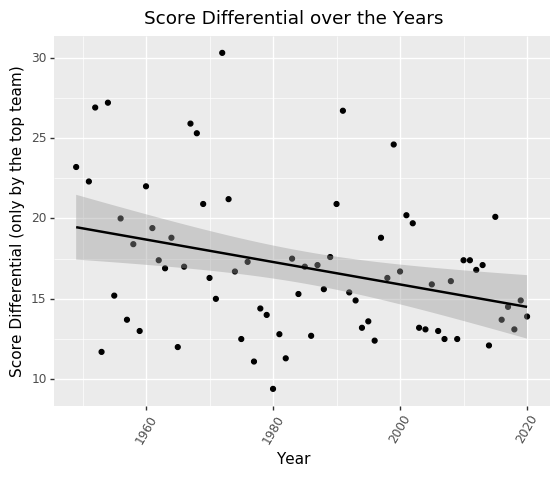

<ggplot: (305181289)>

In [165]:
(ggplot(points, aes(x= 'year', y = 'differential')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Score Differential (only by the top team) ') +
ggtitle('Score Differential over the Years') +
geom_smooth(method = 'lm'))


# On the other hand, the best teams aren't winning by nearly as much anymore.
# This does have a statistically significant difference, providing a modeling equation of 
# differential = 2010.7460 - 1.5203(year)
# The p-value of .006 shows that this difference is statistically significant. 
# In context, this means that over the years, CBB games have gotten closer over time, and the best teams 
# don't blow out their opponents nearly as often.

In [166]:
diff_res = sm.ols('year~differential', data=points).fit()
diff_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     8.196
Date:                Wed, 13 May 2020   Prob (F-statistic):            0.00556
Time:                        14:30:16   Log-Likelihood:                -311.27
No. Observations:                  71   AIC:                             626.5
Df Residuals:                      69   BIC:                             631.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2010.7460      9.296    216.297      0.000    1992.201    2029.292
differential    -1.5203      0.531     -2.863      0.006      -2.580      -0.461
==============================================================================
Omnibus:                       15.692   Durbin-Watson:                   0.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                3.856
Skew:                          -0.011   Prob(JB):                        0.145
Kurtosis:                       1.858   Cond. No.                         69.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""